# 03_EDA: Analyzing Features and Their Importance to Recommendations

**Description**: Looking at the distribution of certain features. In addition, some feature sets were modified slightly if the underlying information was incorrect. 

**Disclaimer**: The majority of data analysis will come after the recommender has been generated, in `06_feat_relationships`.

## Table of Contents

1. [Loading in Tables for EDA](#1)  
2. [Merging Datasets](#2)  
3. [General Feature Counts](#3)  

In [1]:
from collections import defaultdict
import pickle
import re

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

%matplotlib inline

<a name="1"></a>
## 1. Loading In Tables for EDA

In [2]:
artists = pd.read_csv('../data/artist_list_v2.csv').set_index('s_artist_id')
songs = pd.read_csv('../data/song_list_v2.csv').set_index('s_song_id')
genres = pd.read_csv('../data/genres.csv')
gs = pd.read_csv('../data/gsong_lookup.csv').set_index('gs_id')
sec_means = pd.read_csv('../data/spotify_section_means.csv')
sec_var = pd.read_csv('../data/spotify_section_var.csv')
song_feats = pd.read_csv('../data/song_feats.csv').set_index('id')
timbre_means = pd.read_csv('../data/timbre_means.csv')
timbre_var = pd.read_csv('../data/timbre_var.csv')
pitch_means = pd.read_csv('../data/pitch_means.csv')
pitch_var = pd.read_csv('../data/pitch_var.csv')

In [3]:
timbre_means.rename({'Unnamed: 0':'song_id'}, axis= 1, inplace=True)
timbre_var.rename({'Unnamed: 0':'song_id'}, axis= 1, inplace=True)
pitch_means.rename({'Unnamed: 0':'song_id'}, axis= 1, inplace=True)
pitch_var.rename({'Unnamed: 0':'song_id'}, axis= 1, inplace=True)
sec_means.rename({'Unnamed: 0':'song_id', 'confidence':'mean_song_conf',
                  'loudness':'mean_loudness', 'mode':'mean_mode', 
                 'mode_confidence': 'mean_mode_conf', 'tempo':'mean_tempo',
                  'tempo_confidence':'mean_tempo_conf'}, 
                 axis= 1, inplace=True)
sec_var.rename({'Unnamed: 0':'song_id', 'confidence':'var_song_conf',
                  'loudness':'var_loudness', 'mode':'var_mode', 
                 'mode_confidence': 'var_mode_conf', 'tempo':'var_tempo',
                  'tempo_confidence':'var_tempo_conf'}, 
                 axis= 1, inplace=True)

In [4]:
timbre_means.set_index('song_id', inplace=True)
timbre_var.set_index('song_id', inplace=True)
pitch_means.set_index('song_id', inplace=True)
pitch_var.set_index('song_id', inplace=True)
sec_means.set_index('song_id', inplace=True)
sec_var.set_index('song_id', inplace=True)

In [5]:
timbre_means.rename(columns = lambda x: 'tm_' + x, inplace=True)
timbre_var.rename(columns = lambda x: 'tv_' + x, inplace=True)
pitch_means.rename(columns = lambda x: 'pm_' + x, inplace=True)
pitch_var.rename(columns = lambda x: 'pv_' + x, inplace=True)

In [6]:
sec_means.drop('duration', axis=1, inplace=True)
sec_var.drop('duration', axis=1, inplace=True)

In [7]:
genres = pd.read_csv('../data/genres.csv')
genres.rename({'Unnamed: 0':'genre_id'}, axis= 1, inplace=True)
genres.set_index('genre_id', inplace=True)

In [8]:
song_feats.drop('duration_ms', axis=1, inplace=True)

<a name="2"></a>
## 2. Merging Datasets

### 2a. Merging `songs` & `song_feats` Dataframes

In [9]:
main_wfeats = pd.merge(songs, song_feats, left_on=songs.index, right_on=song_feats.index)

In [10]:
main_wfeats.shape

(22892, 21)

In [13]:
main_wfeats.rename({'key_0':'song_id'}, axis=1, inplace=True)

##### Sanity Check of Merged df

In [14]:
main_wfeats.head(1)

,song_id,album_release_date,artist_id,artist_name,duration_ms,explicit,linked_album,song_title,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,key_changes
0,6SluaPiV04KOaRTOIScoff,1995-10-13,6UE7nl9mha6s8z0wFQFIZ2,Robyn,229226.0,False,Robyn Is Here,Show Me Love - Radio Version,0.546,0.643,...,-4.069,0,0.0437,0.0746,0.0,0.213,0.706,181.838,4,7


### 2b. Adding In Section + Segment Based Features

##### Adding Section Means

In [15]:
main_wfeats = main_wfeats.merge(sec_means, left_on='song_id', right_on='song_id')

##### Adding Variance of Sections

In [16]:
main_wfeats = main_wfeats.merge(sec_var, left_on='song_id', right_on='song_id')

##### Adding Pitch and Timbre Features

In [17]:
main_wfeats = main_wfeats.merge(timbre_means, left_on='song_id', right_on='song_id')
main_wfeats = main_wfeats.merge(timbre_var, left_on='song_id', right_on='song_id')
main_wfeats = main_wfeats.merge(pitch_means, left_on='song_id', right_on='song_id')
main_wfeats = main_wfeats.merge(pitch_var, left_on='song_id', right_on='song_id')

<a name="3"></a>
## 3. General Feature Counts

Here, I looked at the general distritubion of a number of features, to a) ensure that there are no errors, or funny values present, and b) to help determine what will be the most influential features in determining song similarity.

### 3a. Time Signature

In [18]:
main_wfeats['time_signature'].value_counts()

4    21150
3     1421
5      204
1      114
0        2
Name: time_signature, dtype: int64

In [19]:
main_wfeats[main_wfeats['time_signature'] == 0]

,song_id,album_release_date,artist_id,artist_name,duration_ms,explicit,linked_album,song_title,danceability,energy,...,pv_dim_3,pv_dim_4,pv_dim_5,pv_dim_6,pv_dim_7,pv_dim_8,pv_dim_9,pv_dim_10,pv_dim_11,pv_dim_12
15423,5OiLJ8tjUPFiPX2gVM8fxJ,2009-01-01,1yxSLGMDHlW21z4YXirZDS,The Black Eyed Peas,257560.0,False,THE E.N.D. (THE ENERGY NEVER DIES),Imma Be,0.619,0.539,...,0.399147,0.334048,0.441041,0.568762,0.376905,0.408359,0.315816,0.303287,0.201750,0.277836
18310,3FepYSKnGMMlR9URg0PSuR,1987-01-01,2GMH35k5oLCjzYpn5HbaD8,Lawrence Welk,152093.0,False,22 All Time Big Band Favorites,String Of Pearls,0.000,0.152,...,0.213002,0.252626,0.234096,0.229861,0.162083,0.391253,0.350463,0.294521,0.205734,0.194655


The time signature of '0' is not correct for the above songs (it just doesn't make sense). I've found the correct time signatures for both:

- Black Eyed Peas "Imma Be" appears to be [4/4](https://www.musicnotes.com/sheetmusic/mtd.asp?ppn=MN0113455). 
- The Jerry Gray composed, "String of Pearls" appears to be [4/4](https://www.sheetmusicplus.com/title/a-string-of-pearls-for-string-quartet-digital-sheet-music/20243650?utm_medium=cpc&adpos=1o1&gclid=CjwKCAjw0oveBRAmEiwAzf6_rJpE4rV7Y8vsiMiiM1_86FkwoBBR4mw3uxcbriTmx1-KYHVgY_RvuBoCnQ4QAvD_BwE&d=sem_sidecar&d=sem_sidecar&d=sem_ggl_{campaign_id}_&popup=false&popup=false&utm_source=google&ac=1&country_code=USA&sc_intid=20243650&scid=scplp20243650) as well.

In [20]:
main_wfeats['time_signature'] = main_wfeats['time_signature'].apply(lambda x: x + 4 if x is 0 else x)

##### Exporting to `csv`

In [21]:
main_wfeats.to_csv('../data/main_wfeats.csv')

### 3b. Looking Through Decades (by Release Year)

Looking at the distribution of songs by release year to possibly unearth any patterns in the dataset. Some of the release dates are stored as `MM-DD-YYYY`, and others are just `YYYY`, I'll convert all to `YYYY` to ensure uniformity.

In [22]:
main_wfeats['album_release_date'] = main_wfeats['album_release_date'].apply(lambda x: x + '-01-01' if len(x) == 4 else x)
main_wfeats['album_release_date'] = main_wfeats['album_release_date'].apply(lambda x: re.sub(r'(-\d*)','',x))
main_wfeats['album_release_date'] = main_wfeats['album_release_date'].apply(lambda x: int(x))

#### All Songs by Year

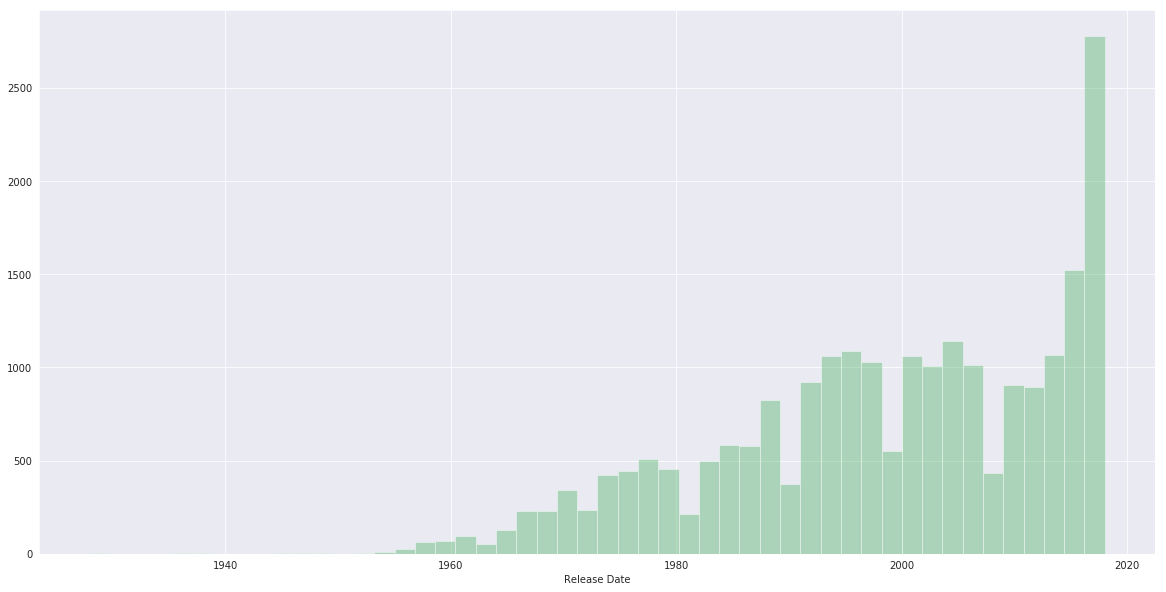

In [23]:
plt.figure(figsize=(20,10))
sns.set_style(style='darkgrid')
sns.distplot(main_wfeats['album_release_date'], kde=False, color='#4eb264', )
plt.xlabel('Release Date');

#### Top 5 Release Years in Dataset

In [24]:
main_wfeats['album_release_date'].value_counts().head()

2018    1571
2017    1207
2015     780
2016     744
2005     620
Name: album_release_date, dtype: int64

It seems as though the vast majority of songs within this dataset have been released after 1990. This could be for several reasons:
- It's just indicative of what people are listening to in 2018. Even though these artists received awards through different decades, they could've released new music which would be more popular currently.
- 

That being said, it would be interesting to see the distribution of when music in the RIAA Gold and Platinum database was actually released, to get a scope of the share of artists per decade. Unfortunately, I haven't had the time to do this research yet, though it is something I hope to do soon.

### 3c. Looking at the Distribution of Genres

#### What Exactly are the Genres?

The website, 'Every Noise at Once' provides a great overview of the genres on Spotify, and based on an interview with Glenn McDonald at the Spotify [blog](https://artists.spotify.com/blog/how-spotify-discovers-the-genres-of-tomorrow).

#### The Top-10 Most Popular Genres Tied to Songs

In [23]:
top10_genres = gs['genre_name'].value_counts().head(10)

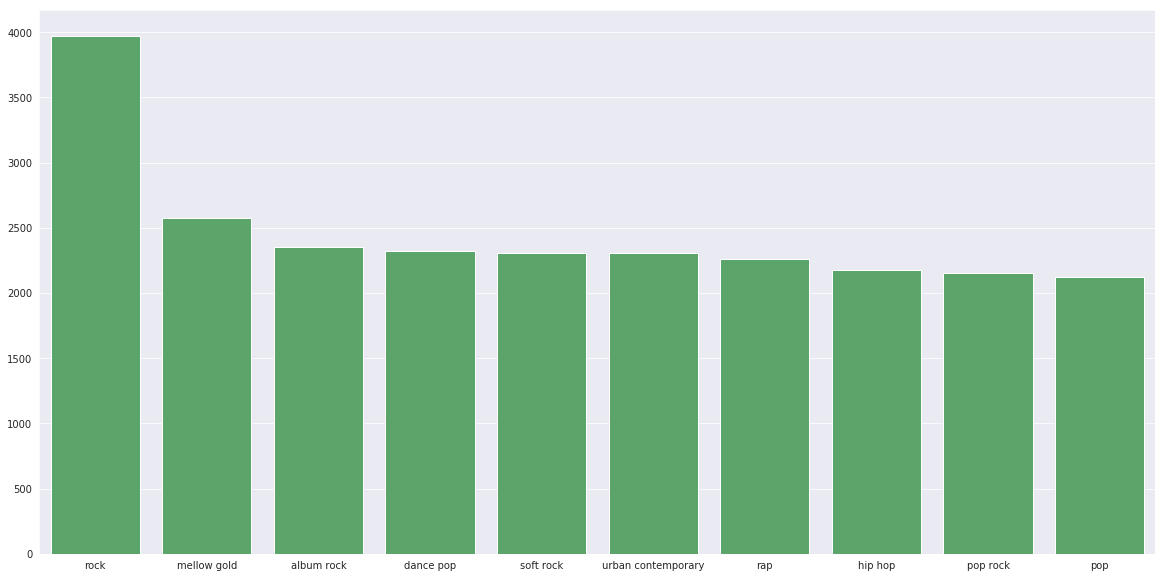

In [24]:
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
sns.barplot(top10_genres.index, top10_genres.values, color='#4eb264');

#### The Top-10 Most Least Popular Genres Tied to Songs

In [25]:
bottom10_genres = gs['genre_name'].value_counts().tail(10)

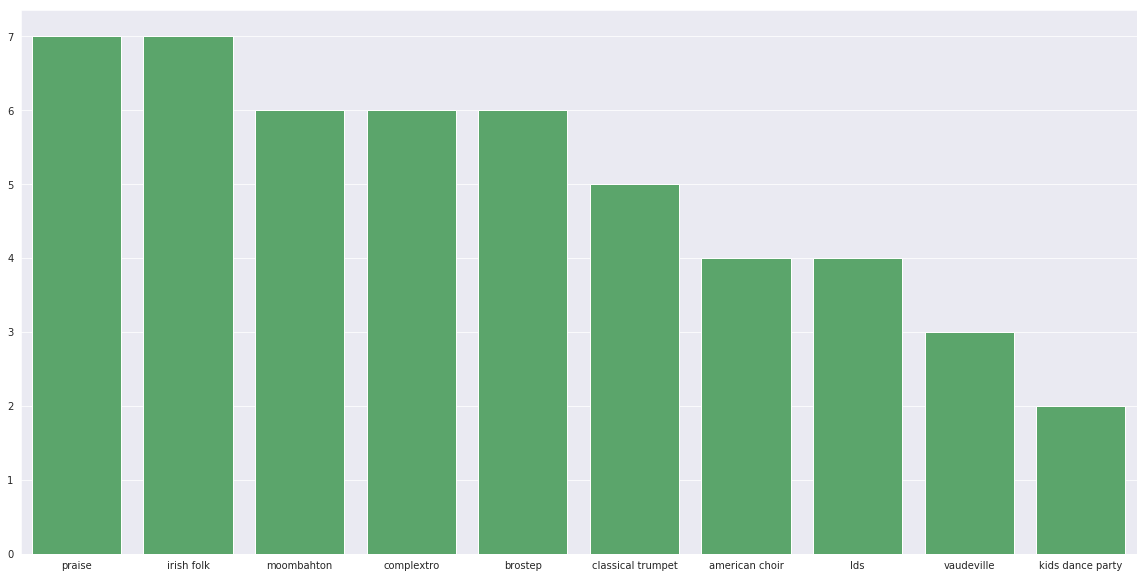

In [26]:
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
sns.barplot(bottom10_genres.index, bottom10_genres.values, color='#4eb264');

**Analysis**: With the exception of rock, the top-10 most popular genres have very similar counts. I suspect this is because much of the music in this dataset is relatively new, and that many of these genres are listed next to one another on the same songs (urban contemporary and hip hop are frequently linked, for instance). 

On the opposite end of the spectrum, there are number of genres with very few associated song titles. Going into crafting the cosine similarity matrix, I assumed this would've had a harmful effect on the strength of recommendations for songs with those associated genres, especially if they did not have additional genres to help further define their respective musical style. We'll look at how it actually affected recommendations for those songs within the `05_cosine` notebook.

#### Next notebook: 04_preprocessing